# Salary prediction by job description

### 1. Introduction
In this notebook I'm going to build several Neural Network (NN) models whcih will be able to predict expected salary by the job description. Our models will utilize several approaches for descriptions processing:
1. **Pure convolutional approach** (1D convolution)
2. **Pure recurrent approach** (Bidirectional LSTM)
3. **Mix of convolutional and recurrent approaches**

I hope this work will provide you with some meaningful insights, or at least you can pick up some tricks for using Keras in a more advanced way :) 

After such a short explanation, we will begin with importing standart libraries for ML tasks. As I hinted above, we will use Keras for building NNs (its import you will see further in the code). In cell 2 I check whether tensorflow (and Keras accordingly) can see my GPU, because it's not a secret that using GPU for training is much more efficient than CPU. Seems that everything works fine, and now we can look at the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
import tensorflow as tf
#check if tensorflow can see my GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 2. Data overview and preprocessing

### 2.1 Overview and simple transformations

We will work with a dataset consisting of a large number of rows representing individual job ads in the UK, and a series of fields about each job ad. The file with data can be found in the repository with this notebook or in this Kaggle competition (with a more detailed overview of the data) - https://www.kaggle.com/c/job-salary-prediction/data

As you can easily guess, the dataset contatins various job descriptions (fields "Title" and "FullDescription") and salaries offered for these positions (field "SalaryNormalized"). Apart from this information the dataset has several additional fields such as "LocationNormalized", "ContractType",  "ContractTime" and others. View of the full dataset is presented in cell 4.

We will not consider all features, some of them have no sense for our task. We will take the following ones:
1. "Title" - full title of a position
2. "FullDescription" - full decription of a postition (including duties, required skills etc.)
3. "Category" - type of a position (e.g. Engineering Jobs, Healthcare & Nursing Jobs)
4. "Company" - full name of a company offering a particular position
5. "LocationNormalized" - normalized location of a company 
6. "ContractType" - full_time or part_time, interpreted by Adzuna from description or a specific additional field received from the advertiser
7. "ContractTime" - permanent or contract, interpreted by Adzuna from description or a specific additional field received from the advertiser
8. "SalaryNormalized" - our target, salary amount (with some transformations)

You could notice that for the field "SalaryNormalized" I mentioned "some transformations". The thing is, salaries distribution in the original dataset is shifted to lower values (check cell 5), which is not good for models fitting. Usually, symmetric distributions of the targret are more preferable. So, we could use straigtforward log1p transformation to make it more symmetric (check again cell 5). log1p formula is very simple: *salary_transformed=log(1+salary_original)*.

Finally, let's group our columns by their meanings (check cell 6). Text columns cotain ["Title", "FullDescription"], categorical columns contain ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"], and our target column is "Log1pSalary".

In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)

In [4]:
print(data.shape)
data.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


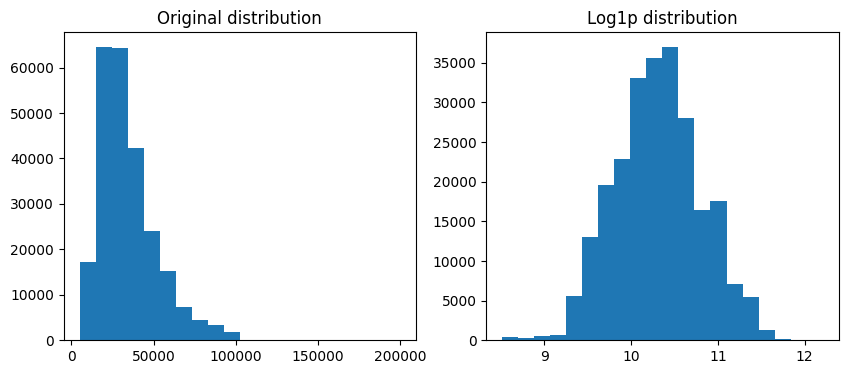

In [5]:
#log1p transformation of the salary column
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

#plot original salaries distirbution
plt.figure(figsize=[10, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.title("Original distribution");

#plot transformed salaries distirbution
plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title("Log1p distribution");

In [6]:
#group columns by their meaning
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

#cast missing values to string "NaN"
data[categorical_columns] = data[categorical_columns].fillna('NaN') 


### 2.2 Text columns preprocessing

Now we are ready to transform our text columns ("Title", "FullDescription") to a more appropriate form. We will do it using NLTK library (a leading platform to work with human language). Following transformations take place:
1. **Tokenization** using WordPunctTokenizer
2. **Lemmatization** using WordNetLemmatizer
3. **Filtering stopwords** using NLTK's english stopwords
4. **Filtering punctuation** 
5. **Join all preprocessed tokens with a space**

All these operations are written in the *text_normalization* function (check cell 7). For lemmatization we also use additional *nltk_pos_tagger* function which match particular token with its part of speech to help WordNetLemmatizer do its job more correctly.

In [7]:
#importing NLTK's tools
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

#downloading necessary NLTK's packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk_stop_words = set(stopwords.words("english"))
punctuations="?:!.,;"

def nltk_pos_tagger(nltk_tag):
    
    """Match token with its part of speech"""
    
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def text_normalization(text):
    
    """Perform text preprocessing: tokenization, lemmatization, filtering, and join tokens with a space"""  
    
    #Tokenization
    tokenizer=WordPunctTokenizer()
    nltk_tokenList = tokenizer.tokenize(str(text).lower())
        
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    
    nltk_tagged = nltk.pos_tag(nltk_tokenList)  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged) #match tokens with their part of speech
    
    nltk_lemmaList = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            nltk_lemmaList.append(word)
        else:        
            nltk_lemmaList.append(lemmatizer.lemmatize(word, tag))
                                  
    #Filter stopword and punctuation
    filtered_sentence = []  
    for w in nltk_lemmaList:  
        if w not in nltk_stop_words and w not in punctuations:  
            filtered_sentence.append(w)
            
    return ' '.join(filtered_sentence)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mcman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mcman\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mcman\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [9]:
#apply text normalization to the text columns
data['FullDescription']=data['FullDescription'].apply(lambda x: text_normalization(x))
data['Title']=data['Title'].apply(lambda x: text_normalization(x))

In [10]:
print("Tokenized and normalized:")
print(data["FullDescription"][2::100000])

Tokenized and normalized:
2         mathematical modeller / simulation analyst / o...
100002    successful high achieve specialist school lond...
200002    web designer html cs javascript photoshop illu...
Name: FullDescription, dtype: object


### 2.3 Text columns vectorization

After preprocessing we need to vectorize our text columns, that is transform text into fixed-size vectors with token indices. Let's start with splitting the dataset into train and validation sets (check cell 11). This is quite important step, since we have to build our vocabulary only on the train set to avoid data leaks from validation.

In [11]:
#split data into train and validation sets
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


At first, let's see how many time each unqiue token occurs in the train set in both "Title" and "FullDescription" columns (check cells 12, 13). From the graph in cell 14 we can see that many of unique tokens occur very few times, let's cut them! We will consider tokens that occur at leat 10 times (check cell 15), we will also add two special tokens "UNK" - for unknown words and "PAD" to pad our text vectors to the fix size (again check cell 15).

In [12]:
# Count how many times each token occurs in both "Title" and "FullDescription" in total (for data_train only!)
# build a dictionary { token -> it's count }
from collections import Counter
token_counts = Counter()

for row in data_train["FullDescription"]:
    token_counts.update(row.split())
    
for row in data_train["Title"]:
    token_counts.update(row.split())


In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 172350
('****', 544959)
('/', 443362)
('work', 404888)
('experience', 358286)
('role', 250338)
...
('implemen', 1)
('executivecity', 1)
('daredevil', 1)


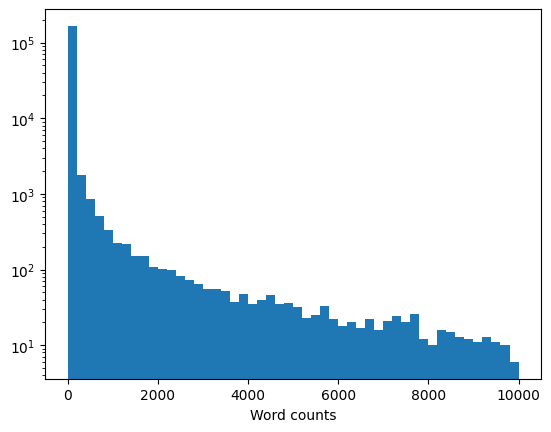

In [14]:
#distribution of token counts
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

In [15]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the train dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words (padding)
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [16]:
print("Vocabulary size:", len(tokens))

Vocabulary size: 26723


In cell 17 we assign an index to each unique token.

In [17]:
#Assign indices to unique tokens
token_to_id=dict(zip(tokens, range(len(tokens))))
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

In the last step (cell 18), we create a special function *as_matrix* which converts text columns to a matrix NxM of fixed-size vectors, where N - number of the input data rows and M - size of each vector. This function has parameter *max_len* which sets size of the vectors (M), by default (*max_len=None*) M equals the maximum number of tokens among all input rows. As you might guess, texts shorter than *max_len* are right-padded with "PAD" token, while the ones longer than *max_len* are cut off.

In [18]:
#get indices of UNK and PAD tokens
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    
    """ Convert input text rows into a matrix with padding """
    
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [19]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering system analyst
hr assistant
senior ec & engineer

Matrix:
[[ 8424 23551  1772     1]
 [11694  2313     1     1]
 [21624  7935    14  8422]]


### 2.4 Categorical columns preprocessing
Finishing with data preprocessing, we need to transform categorical features. At first, we will pick up top-1k most frequent companies from data_train and set "Other" to the field "Company" for companies which are not in top-1k (check cell 20). This step will reduce memory usage for encoding categorical features. After that, for each categotical features we will train TfidfVectorizer, since it shows better performance than some simple tools like CountVectorizer (check cell 21).

In [20]:
# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data_train['Company']).most_common(1000))
recognized_companies = set(top_companies)

#set "Other" to companies that are not in top-1k 
data_train["Company"] = data_train["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")
data_val["Company"] = data_val["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

In [21]:
#create and fit TfidfVectorizers for categorical features
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer_Category = TfidfVectorizer(stop_words='english', max_df=0.95, dtype=np.float32)
tfidf_vectorizer_Category.fit(data_train['Category'])

tfidf_vectorizer_Company = TfidfVectorizer(stop_words='english', max_df=0.95, dtype=np.float32)
tfidf_vectorizer_Company.fit(data_train['Company'])

tfidf_vectorizer_LocationNormalized = TfidfVectorizer(stop_words='english', max_df=0.95, dtype=np.float32)
tfidf_vectorizer_LocationNormalized.fit(data_train['LocationNormalized'])

tfidf_vectorizer_ContractType = TfidfVectorizer(stop_words='english', max_df=0.95, dtype=np.float32)
tfidf_vectorizer_ContractType.fit(data_train['ContractType'])

tfidf_vectorizer_ContractTime = TfidfVectorizer(stop_words='english', max_df=0.95, dtype=np.float32)
tfidf_vectorizer_ContractTime.fit(data_train['ContractTime'])

TfidfVectorizer(dtype=<class 'numpy.float32'>, max_df=0.95,
                stop_words='english')

## 3. Models

### 3.1 View of the batch
Let's combine all preprocessed data and create some batches which will be used for training later. Function *make_batch* join all considered columns in a single dictionary with the following keys: 'Title', 'FullDescription', 'Categorical', 'Log1pSalary'. Don't be surprised, these dictionaries are acceptable for Keras *fit* and *fit_generator* methods, so they will be passed with no problems.

In cell 23 you can look at the view of our batch consisting of 3 data rows. In cells 24 and 25 lengths of title and decription vectors are presented (7 and 425 respectively). Note that since we didn't pass any values for *max_len* parameter, dimensionalities of text vectors are determined by maximum number of tokens among input data rows (seperately for "Title" and "FullDescription" columns). It means that when we will train our models, diffirent batches will probably have different dimensionalities of text vectors. It may confuse, but this strategy helps to train model on the full amount of data not restricting it to only max_len vectors.  

Finally, in cell 26 dimensionality of categorical features vector is presented. Not hard to guess that it will be fixed for all batches.

In [22]:
def make_batch(data, max_len=None, word_dropout=0):
    
    """
    Creates a keras-friendly dict from the batch data.
    param word_dropout: replaces token index with UNK_IX with this probability
    returns: a dict with {
                          'title' : [vectors of length title_max_len], 
                          'FullDescription': [vectors of length description_max_len],
                          'Categorical': [vectors of length n_cat_features],
                          'Log1pSalary': [log1p(salary)]
                          }
    """
    
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = np.array(np.concatenate((tfidf_vectorizer_Category.transform(data['Category']).todense(),
                                           tfidf_vectorizer_Company.transform(data['Company']).todense(),
                                           tfidf_vectorizer_LocationNormalized.transform(data['LocationNormalized']).todense(),
                                           tfidf_vectorizer_ContractType.transform(data['ContractType']).todense(),
                                           tfidf_vectorizer_ContractTime.transform(data['ContractTime']).todense()
                                          ), axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    
    """Additional function for the "make_batch" function, replaces token index with UNK_IX with the 1-keep_prop probability""" 
    
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [23]:
#view of a batch
small_batch=make_batch(data_train[:3])
small_batch

{'Title': array([[21624, 23352, 26331,     1,     1,     1,     1],
        [22859,   174, 14997, 15686, 18199,  3254,     1],
        [ 8268, 23750, 13878,    30,  6797, 22795,    58]]),
 'FullDescription': array([[21624, 23352, 26331, ...,     1,     1,     1],
        [22859,   174, 14997, ...,   174,     0,    74],
        [17261,  5038,  6384, ...,     1,     1,     1]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

In [24]:
#shape of the "Title" field of a batch consisting of 3 data rows
small_batch['Title'].shape

(3, 7)

In [25]:
#shape of the "FullDescription" field of a batch consisting of 3 data rows
small_batch['FullDescription'].shape

(3, 425)

In [26]:
#size of the categorical features vector
n_cat_features=small_batch['Categorical'].shape[1]
n_cat_features

3440

### 3.2 Pre-trained word embeddings
Having determined text vectors consisting of token indices, we cerainly need to transform these indices into word embeddings. There are three main strategies for doing this: ask models to train them from scratch, intialize with pretrained on large text corpus and fix them, intialize with pretrained on large text corpus and fine-tune them. Of course, the third way is usually much better since we provide our models with knwoledge from large text corpus and then "adjust" this knwoledge to a specific task. So, for our models (except for baseline) we will use the third strategy. 

The choice of pre-trained word embeddings is huge, but the most widespread are GloVe embeddings trained on wikipedia texts and on twits. For our task we will chose wiki embeddings since they showed a higher number of matches with our unique tokens (check section "Appendx" cell 70).

For downloading wiki embeddings we will use *gensim* library and its *api* class (check cell 27). I decided to choose embedding vectors of size 100 ('glove-wiki-gigaword-100'). Function *make_embedding_matrix* creates an embedding matrix where row *i* corresponds to the pre-trained embedding vector for word with index *i* from *token_to_id*. If a word wasn't found in the wiki embeddings than we intialize it with the uniformly distributed values from -1 to 1 and increase *misses* count to see how many words were missed (check cells 28 and 29).   




In [27]:
#download pre-trained GloVe wiki embeddings with the embedding vector size 100
import gensim.downloader as api
embeddings_wiki=api.load('glove-wiki-gigaword-100')

In [28]:
def make_embedding_matrix(token_to_id, embs):
    
    """
    Creates embedding matrix where row i corresponds to the pre-trained embedding vector for the word with index i from 
    token_to_id.
    If a word was not found,initializes embedding vector with uniformly distributed values from -1 to 1.
    Also count missed and converted words.
    
    """

    num_tokens = len(token_to_id)
    
    hits = 0
    misses = 0

    embedding_dim = len(embs['the'])
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in token_to_id.items():
        try:
            embedding_matrix[i]=embs.get_vector(word)
            hits += 1
        except KeyError:            
            embedding_matrix[i]=np.random.uniform(-1, 1, size=embedding_dim)
            misses += 1

    print(f"Converted {hits} words ({misses} misses).")

    return embedding_matrix

In [29]:
embedding_matrix_wiki=make_embedding_matrix(token_to_id, embeddings_wiki)

Converted 20414 words (6309 misses).


### 3.3 Models building
As I have already mentioned, we will use Keras to build our models, because all required functionality is available in this package. We will compare 4 models:
1. **Baseline** - the simplest model, just to start from somewhere. In this model we will use two standart LSTM layers to process text columns (just to remind, text columns are "Title" and "FullDescription"). Also, in contrast to the others, in the baseline model we will **not** initialize embedding layers with pre-trained wiki embeddings, we will ask to learn them from scratch.
2. **Pure convolutional** - here we will process text columns using multi-layer 1D convolutions with different kernel sizes (from 2 to 4).
3. **Pure recurrent** - this model will utilize multi-layer bidirectional LSTMs for text columns. Bottom bidirectional layer will pass its output states to the top bidirectional layer.
4. **Mix convolutional+recurrent** - this model will use pure recurrent approach (model 3) for column "Title" and pure convolutional approach (model 2) for coulmn "FullDescription".

Before we will look at the models' structures, I'd like to emphasize the following things:

A) Models are different only in processing text columns ("Title" and "FullDescription"), **dense layer for categorical features and two final dense layers for regression are the same for all considered models**. 

B) Text columns **"Title" and "FullDescription" are processed separately, each of them is assigned its own layer**. Only after processing with convolutions or RNNs they are concatenated with output from dense layer for categorical features, and combined vector is passed to final dense layers for regression. 

C) **All our models will optimize MSE loss function, while MAE on the validation set will be the target metric**. 

D) Except for the simpler baseline model, I tried to keep the same complexity for all other models, i.e. the numbers of parameters of models 2,3,4 are approximately equal. 

In [30]:
import keras
import keras.layers as L

### 3.3.1 Baseline model
Baseline model includes two separate LSTM layers for "Title" and "FullDescription" columns. Outputs from LSTMs are combined with the output from the categorical dense layer via concatenation, and the result vector is passed to the final regression dense layers. Note one more time that in the baseline model pre-trained wiki embeddings are not used, and embedding layers are initialized with the standart 'uniform' Keras initializer. 

Function *build_baseline_model* creates a model with the described structure, MSE loss and MAE as the target metric. The model contains 5 810 901 trainable params (check cell 32). Structure of the model is drawn in cell 33.

In [31]:
def build_baseline_model(n_tokens=len(tokens), n_cat_features=n_cat_features, 
                             hid_size=64):
    
    """ 
    Build baseline model that maps three data sources ("Title", "FullDescription", "Categorical") to a single linear 
    output: predicted log1p(salary) 
    
    """
    
    #input layers for "Title", "FullDescription" and categorical_columns
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")

    #embedding layers for "Title" and "FullDescription" (not initialized with pre-trained wiki embeddings)
    emb_title=L.Embedding(n_tokens,100, trainable=True, name="Embedding_title")(l_title)
    emb_descr=L.Embedding(n_tokens,100, trainable=True, name="Embedding_description")(l_descr)
    
    #LSTM layers for "Title" and "FullDescription"
    title_LSTM=L.LSTM(units=15, name="LSTM_title")(emb_title)
    descr_LSTM=L.LSTM(units=45, name="LSTM_description")(emb_descr)
    
    #dense layer for categorical features
    dense_categ=L.Dense(120, activation='relu', kernel_regularizer='l2', name="Dense_categorical")(l_categ)
    
    #concatenation of result "Title" vector, "FullDescription" vector and categorical vector
    concat=L.Concatenate()([title_LSTM, 
                            descr_LSTM, 
                            dense_categ])
    
    #final dense layers for regression
    final_dense1=L.Dense(100, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_1")(concat)
    final_dense2=L.Dense(20, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_2")(final_dense1)
    output_layer=L.Dense(1)(final_dense2)

    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer], name="Baseline")
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [32]:
baseline_model=build_baseline_model()
baseline_model.summary()

Model: "Baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 Embedding_title (Embedding)    (None, None, 100)    2672300     ['Title[0][0]']                  
                                                                                                  
 Embedding_description (Embeddi  (None, None, 100)   2672300     ['FullDescription[0][0]']        
 ng)                                                                                       

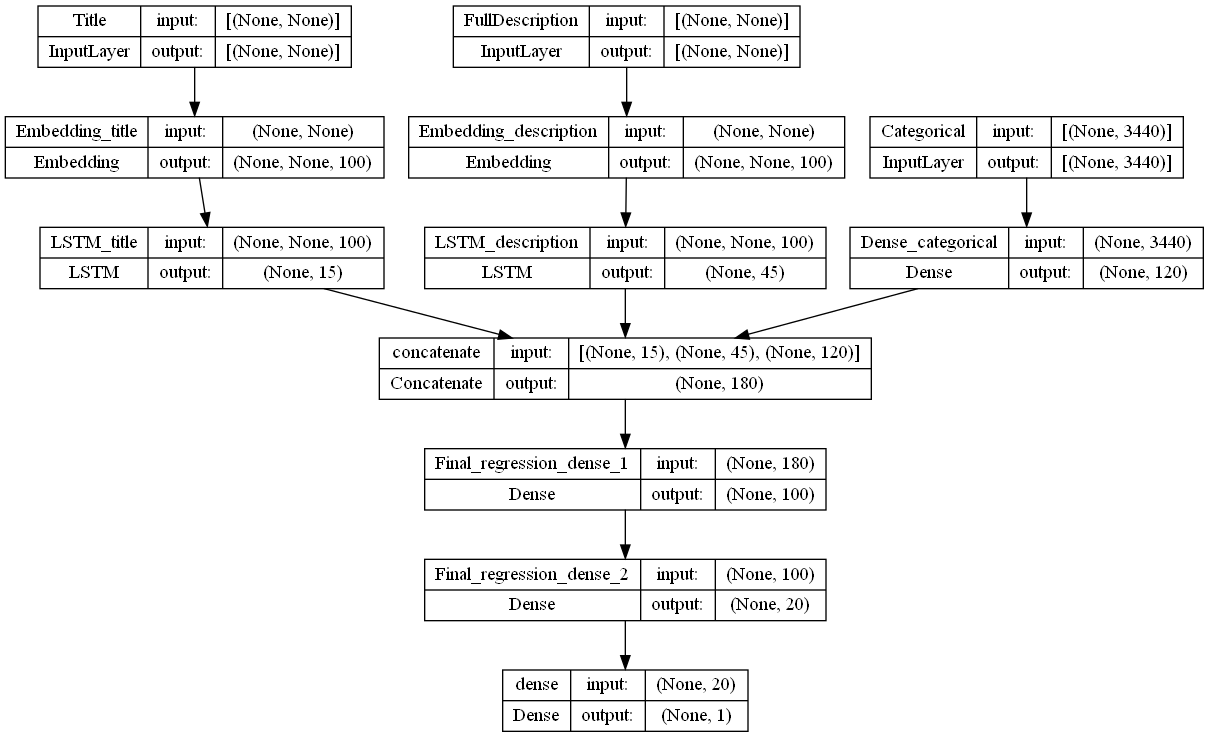

In [33]:
#plot baseline model's sctructure 
from keras.utils.vis_utils import plot_model
plot_model(baseline_model, show_shapes=True, show_layer_names=True)

### 3.3.2 Pure convolutional model
Pure convolutional model includes three multi-layer convolutions for "Title" and three multi-layer convolutions for "FullDescription" (six in total). Bottom convoltuions kernel sizes vary from 2 to 4. Top convolutions kernel size is fixed and equal 2 for all six sub-layers. Outputs from global max pollings after these convolutions are combined with the output from the categorical dense layer via concatenation, and the result vector is passed to the final regression dense layers. Embedding layers are initialized with pre-trained wiki embeddings.

Function *build_model_pure_convolutional* creates a model with the described structure, MSE loss and MAE as the target metric. The model contains 6 008 381 trainable params (check cell 35). Structure of the model is drawn in cell 36 (you can double click on the output of cell to zoom in the structure).

In [34]:
def build_model_pure_convolutional(n_tokens=len(tokens), n_cat_features=n_cat_features, 
                             hid_size=64, embedding_matrix=embedding_matrix_wiki):
    
    """ 
    Build pure convolutional model that maps three data sources ("Title", "FullDescription", "Categorical") to a single 
    linear output: predicted log1p(salary) 
    
    """
    
    #input layers for "Title", "FullDescription" and categorical_columns    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    #embedding layers for "Title" and "FullDescription" (initialized with pre-trained wiki embeddings)
    emb_title=L.Embedding(n_tokens,100, 
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True, name="Embedding_title")(l_title)
    emb_descr=L.Embedding(n_tokens,100,
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True, name="Embedding_description")(l_descr)
    
    #two-layer convolutions for "Title" and "FullDescription" with bottom kernel size 2
    conv_title1_1=L.Conv1D(30,2, activation='relu', name="Bottom_convolution_size2_title")(emb_title)
    conv_descr1_1=L.Conv1D(100,2, activation='relu', name="Bottom_convolution_size2_description")(emb_descr)    
    max_pool_title1_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_title1_1)
    max_pool_descr1_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr1_1)    
    conv_title1_2=L.Conv1D(10,2, activation='relu', name="Top_convolution_size2_title")(max_pool_title1_1)
    conv_descr1_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size2_decription")(max_pool_descr1_1)
    global_max_pool_title_1=L.GlobalMaxPooling1D()(conv_title1_2)
    global_max_pool_descr_1=L.GlobalMaxPooling1D()(conv_descr1_2)
    
    #two-layer convolutions for "Title" and "FullDescription" with bottom kernel size 3
    conv_title2_1=L.Conv1D(50, 3, activation='relu', name="Bottom_convolution_size3_title")(emb_title)
    conv_descr2_1=L.Conv1D(150, 3, activation='relu', name="Bottom_convolution_size3_description")(emb_descr)    
    max_pool_title2_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_title2_1)
    max_pool_descr2_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr2_1)    
    conv_title2_2=L.Conv1D(10,2, activation='relu', name="Top_convolution_size3_title")(max_pool_title2_1)
    conv_descr2_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size3_description")(max_pool_descr2_1)   
    global_max_pool_title_2=L.GlobalMaxPooling1D()(conv_title2_2)
    global_max_pool_descr_2=L.GlobalMaxPooling1D()(conv_descr2_2)
    
    #two-layer convolutions for "Title" and "FullDescription" with bottom kernel size 4
    conv_title3_1=L.Conv1D(70, 4, activation='relu', name="Bottom_convolution_size4_title")(emb_title)
    conv_descr3_1=L.Conv1D(200, 4, activation='relu', name="Bottom_convolution_size4_description")(emb_descr)    
    max_pool_title3_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_title3_1)
    max_pool_descr3_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr3_1)    
    conv_title3_2=L.Conv1D(10,2, activation='relu', name="Top_convolution_size4_title")(max_pool_title3_1)
    conv_descr3_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size4_description")(max_pool_descr3_1)    
    global_max_pool_title_3=L.GlobalMaxPooling1D()(conv_title3_2)
    global_max_pool_descr_3=L.GlobalMaxPooling1D()(conv_descr3_2)
    
    #dense layer for categorical features
    dense_categ=L.Dense(120, activation='relu', kernel_regularizer='l2', name="Dense_categorical")(l_categ)
    
    #concatenation of convolution vectors for "Title" and "FullDescription" and categorical vector
    concat=L.Concatenate()([global_max_pool_title_1, 
                            global_max_pool_title_2, 
                            global_max_pool_title_3, 
                            global_max_pool_descr_1, 
                            global_max_pool_descr_2, 
                            global_max_pool_descr_3, 
                            dense_categ])
    
    
    #final dense layers for regression
    final_dense1=L.Dense(100, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_1")(concat)
    final_dense2=L.Dense(20, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_2")(final_dense1)
    output_layer=L.Dense(1)(final_dense2)
     

    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer], name="Pure_convolutional")
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [35]:
model_pure_convolutional=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_convolutional.summary()

Model: "Pure_convolutional"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 Embedding_title (Embedding)    (None, None, 100)    2672300     ['Title[0][0]']                  
                                                                                                  
 Embedding_description (Embeddi  (None, None, 100)   2672300     ['FullDescription[0][0]']        
 ng)                                                                             

 global_max_pooling1d_5 (Global  (None, 30)          0           ['Top_convolution_size4_descripti
 MaxPooling1D)                                                   on[0][0]']                       
                                                                                                  
 Dense_categorical (Dense)      (None, 120)          412920      ['Categorical[0][0]']            
                                                                                                  
 concatenate_1 (Concatenate)    (None, 240)          0           ['global_max_pooling1d[0][0]',   
                                                                  'global_max_pooling1d_2[0][0]', 
                                                                  'global_max_pooling1d_4[0][0]', 
                                                                  'global_max_pooling1d_1[0][0]', 
                                                                  'global_max_pooling1d_3[0][0]', 
          

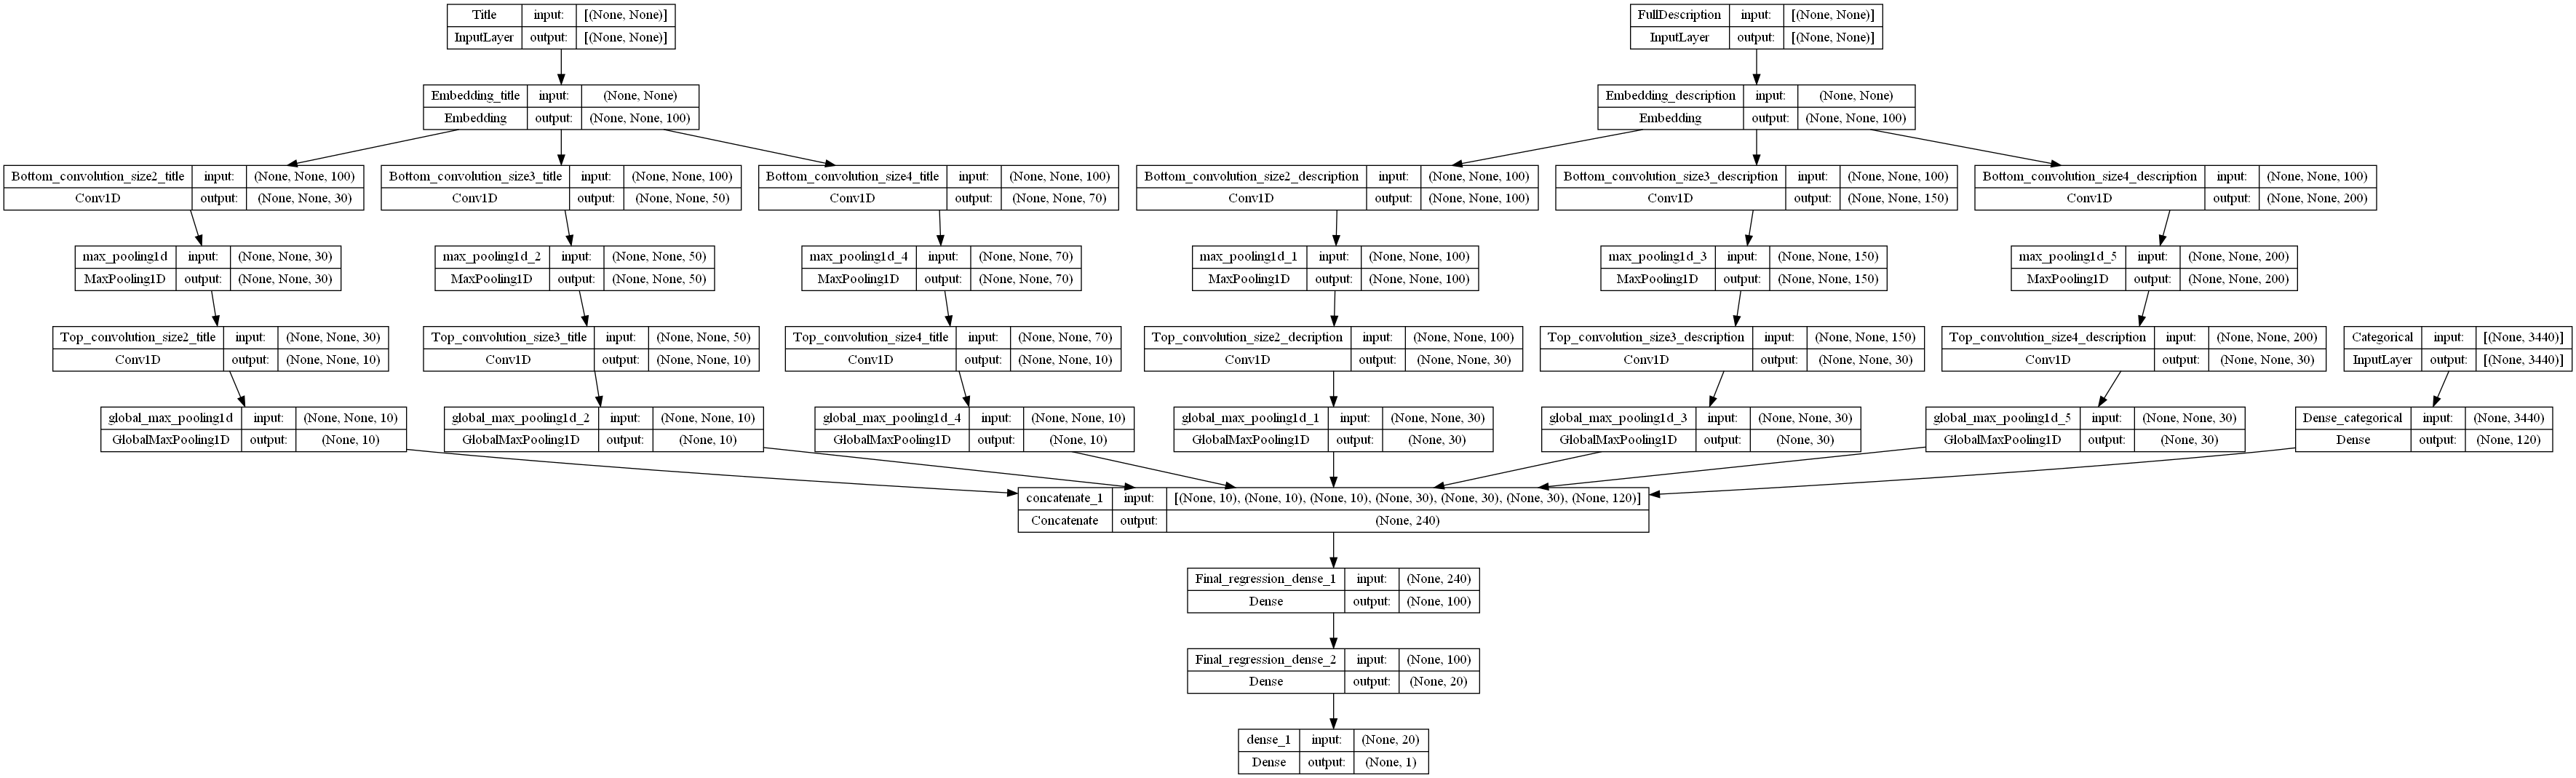

In [36]:
#plot pure convolutional model's sctructure 
plot_model(model_pure_convolutional, show_shapes=True, show_layer_names=True)

### 3.3.3 Pure recurrent model
Pure recurrent model includes one multi-layer bidirectional LSTM for "Title" and one multi-layer bidirectional LSTM for "FullDescription". Bottom bidirectional LSTM layers pass their output states as inputs for the top bidirectional LSTM layers. Outputs from the the top bidirectional LSTM layers are combined with the output from the categorical dense layer via concatenation, and the result vector is passed to the final regression dense layers. Embedding layers are initialized with pre-trained wiki embeddings.

Function *build_model_pure_recurrent* creates a model with the described structure, MSE loss and MAE as the target metric. The model contains 5 986 941 trainable params (check cell 38). Structure of the model is drawn in cell 39.

In [37]:
def build_model_pure_recurrent(n_tokens=len(tokens), n_cat_features=n_cat_features, 
                               hid_size=64, embedding_matrix=embedding_matrix_wiki):
    
    """ 
    Build pure recurrent model that maps three data sources ("Title", "FullDescription", "Categorical") 
    to a single linear output: predicted log1p(salary) 
    
    """
    
    #input layers for "Title", "FullDescription" and categorical_columns  
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    #embedding layers for "Title" and "FullDescription" (initialized with pre-trained wiki embeddings)
    emb_title=L.Embedding(n_tokens,100, 
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True, name="Embedding_title")(l_title)
    emb_descr=L.Embedding(n_tokens,100,
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True, name="Embedding_description")(l_descr)
    
    #bottom bidirectional LSTMs for "Title" and "FullDescription" (pass output state vectors to the top bidirectional LSTMs)
    bi_dir_title_LSTM1=L.Bidirectional(L.LSTM(units=30, return_sequences=True), 
                                       name="Bottom_bidirectional_LSTM_title")(emb_title)
    bi_dir_descr_LSTM1=L.Bidirectional(L.LSTM(units=70, return_sequences=True),
                                       name="Bottom_bidirectional_LSTM_description")(emb_descr)
    
    #top bidirectional LSTMs for "Title" and "FullDescription"
    bi_dir_title_LSTM2=L.Bidirectional(L.LSTM(units=15), name="Top_bidirectional_LSTM_title")(bi_dir_title_LSTM1)
    bi_dir_descr_LSTM2=L.Bidirectional(L.LSTM(units=45), name="Top_bidirectional_LSTM_description")(bi_dir_descr_LSTM1)
    
    #dense layer for categorical features
    dense_categ=L.Dense(120, activation='relu', kernel_regularizer='l2', name="Dense_categorical")(l_categ)
    
    #concatenation of output vectors of top bidirectional LSTMs for "Title" and "FullDescription"  and categorical vector
    concat=L.Concatenate()([bi_dir_title_LSTM2,  
                            bi_dir_descr_LSTM2, 
                            dense_categ])
    
    #final dense layers for regression
    final_dense1=L.Dense(100, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_1")(concat)
    final_dense2=L.Dense(20, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_2")(final_dense1)
    output_layer=L.Dense(1)(final_dense2)
     
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer], name="Pure_recurrent")
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [38]:
model_pure_recurrent=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_recurrent.summary()

Model: "Pure_recurrent"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 Embedding_title (Embedding)    (None, None, 100)    2672300     ['Title[0][0]']                  
                                                                                                  
 Embedding_description (Embeddi  (None, None, 100)   2672300     ['FullDescription[0][0]']        
 ng)                                                                                 

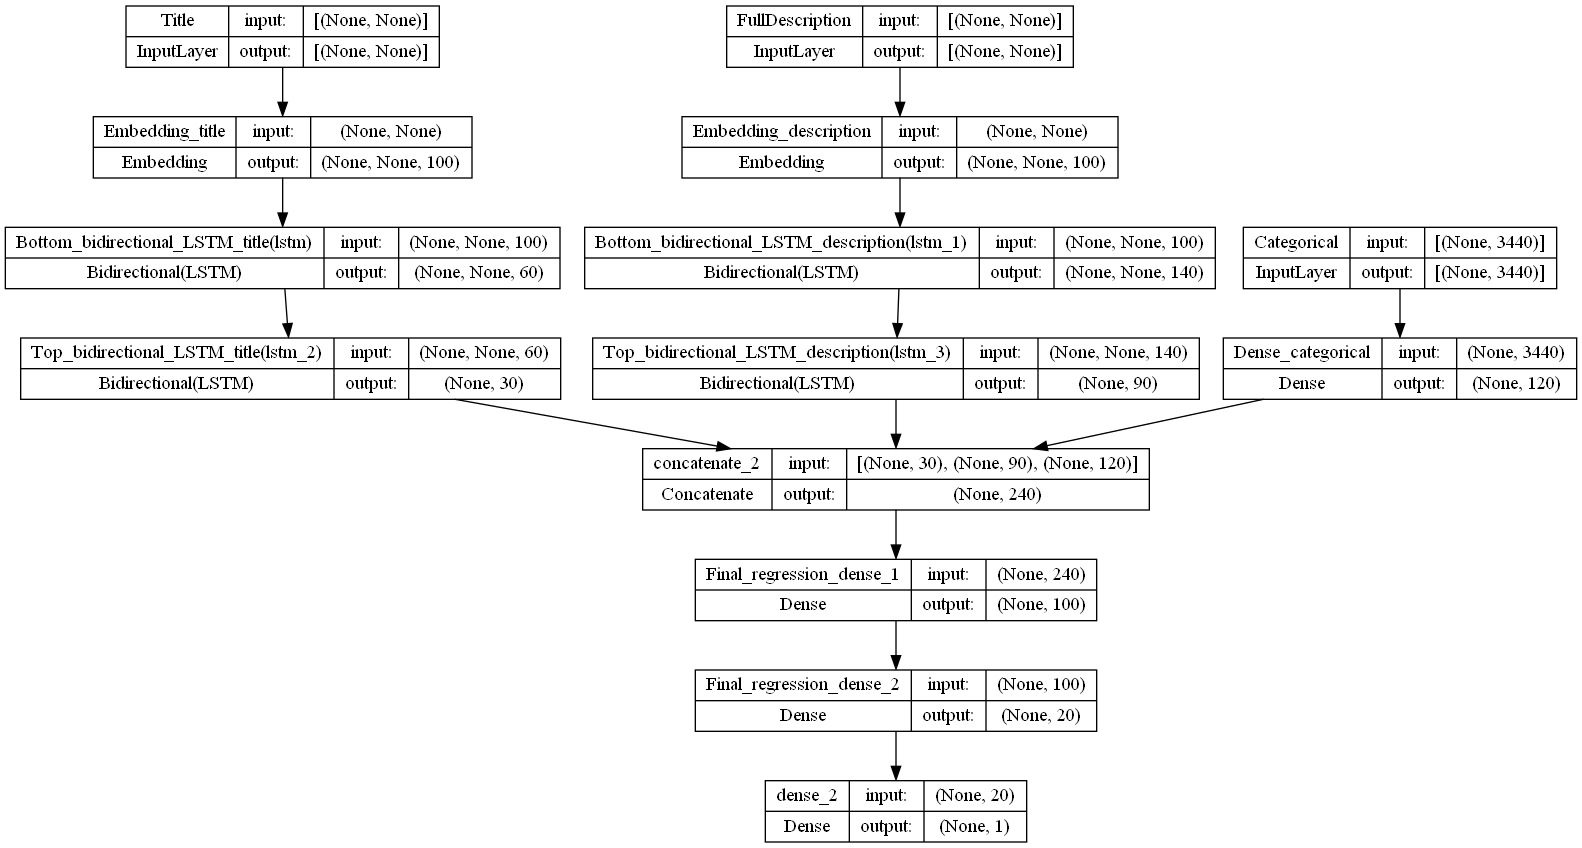

In [39]:
#plot pure recurrent model's sctructure 
plot_model(model_pure_recurrent, show_shapes=True, show_layer_names=True)

### 3.3.4 Mix convolutional+recurrent model
Mix convolutional+recurrent model utilizes pure recurrent approach for "Title" and pure convolutional approach for "FullDescription". Embedding layers are initialized with pre-trained wiki embeddings.

Function *build_model_mix_convolutional_recurrent* creates a model with the described structure, MSE loss and MAE as the target metric. The model contains 5 996 761 trainable params (check cell 41). Structure of the model is drawn in cell 42 (you can double click on the output of cell to zoom in the structure).

In [40]:
def build_model_mix_convolutional_recurrent(n_tokens=len(tokens), n_cat_features=n_cat_features, 
                                            hid_size=64, embedding_matrix=embedding_matrix_wiki):
    
    """ 
    Build mix convolutional+recurrent model that maps three data sources ("Title", "FullDescription", "Categorical") 
    to a single linear output: predicted log1p(salary) 
    
    """
    
    #input layers for "Title", "FullDescription" and categorical_columns  
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    #embedding layers for "Title" and "FullDescription" (initialized with pre-trained wiki embeddings)
    emb_title=L.Embedding(n_tokens,100, 
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True)(l_title)
    emb_descr=L.Embedding(n_tokens,100,
                          embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
                          trainable=True)(l_descr)
    
    #two-layer bidirectional LSTM for "Title"
    bi_dir_title_LSTM1=L.Bidirectional(L.LSTM(units=30, return_sequences=True), 
                                       name="Bottom_bidirectional_LSTM_title")(emb_title)
    bi_dir_title_LSTM2=L.Bidirectional(L.LSTM(units=15), name="Top_bidirectional_LSTM_title")(bi_dir_title_LSTM1)
    
    #two-layer convolutions for "FullDescription" with bottom kernel size 2
    conv_descr1_1=L.Conv1D(100,2, activation='relu', name="Bottom_convolution_size2_description")(emb_descr)
    max_pool_descr1_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr1_1)    
    conv_descr1_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size2_decription")(max_pool_descr1_1)    
    global_max_pool_descr_1=L.GlobalMaxPooling1D()(conv_descr1_2)
    
    #two-layer convolutions for "FullDescription" with bottom kernel size 3
    conv_descr2_1=L.Conv1D(150, 3, activation='relu', name="Bottom_convolution_size3_description")(emb_descr)    
    max_pool_descr2_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr2_1)    
    conv_descr2_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size3_description")(max_pool_descr2_1)
    global_max_pool_descr_2=L.GlobalMaxPooling1D()(conv_descr2_2)

    #two-layer convolutions for "FullDescription" with bottom kernel size 4
    conv_descr3_1=L.Conv1D(200, 4, activation='relu', name="Bottom_convolution_size4_description")(emb_descr)
    max_pool_descr3_1=L.MaxPooling1D(pool_size=2, strides=2)(conv_descr3_1)   
    conv_descr3_2=L.Conv1D(30,2, activation='relu', name="Top_convolution_size4_description")(max_pool_descr3_1)
    global_max_pool_descr_3=L.GlobalMaxPooling1D()(conv_descr3_2)
    
    #dense layer for categorical features
    dense_categ=L.Dense(120, activation='relu', kernel_regularizer='l2', name="Dense_categorical")(l_categ)
    
    #concatenation of output vectors of top bidirectional LSTM for "Title", convolutions for"FullDescription"  
    #and categorical vector
    concat=L.Concatenate()([bi_dir_title_LSTM2, 
                            global_max_pool_descr_1, 
                            global_max_pool_descr_2, 
                            global_max_pool_descr_3, 
                            dense_categ])
    
    final_dense1=L.Dense(100, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_1")(concat)
    final_dense2=L.Dense(20, activation='relu', kernel_regularizer='l2', name="Final_regression_dense_2")(final_dense1)
    output_layer=L.Dense(1)(final_dense2)
         
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer], 
                               name="Mix_convolutional_recurrent")
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [41]:
model_mix_convolutional_recurrent=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_mix_convolutional_recurrent.summary()

Model: "Mix_convolutional_recurrent"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 FullDescription (InputLayer)   [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 100)    2672300     ['FullDescription[0][0]']        
                                                                                                  
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 Bottom_convolution_size2_descr  (None, None, 100)   20100       ['embedding_1[0][0]']            
 iption (Conv1D)                                                        

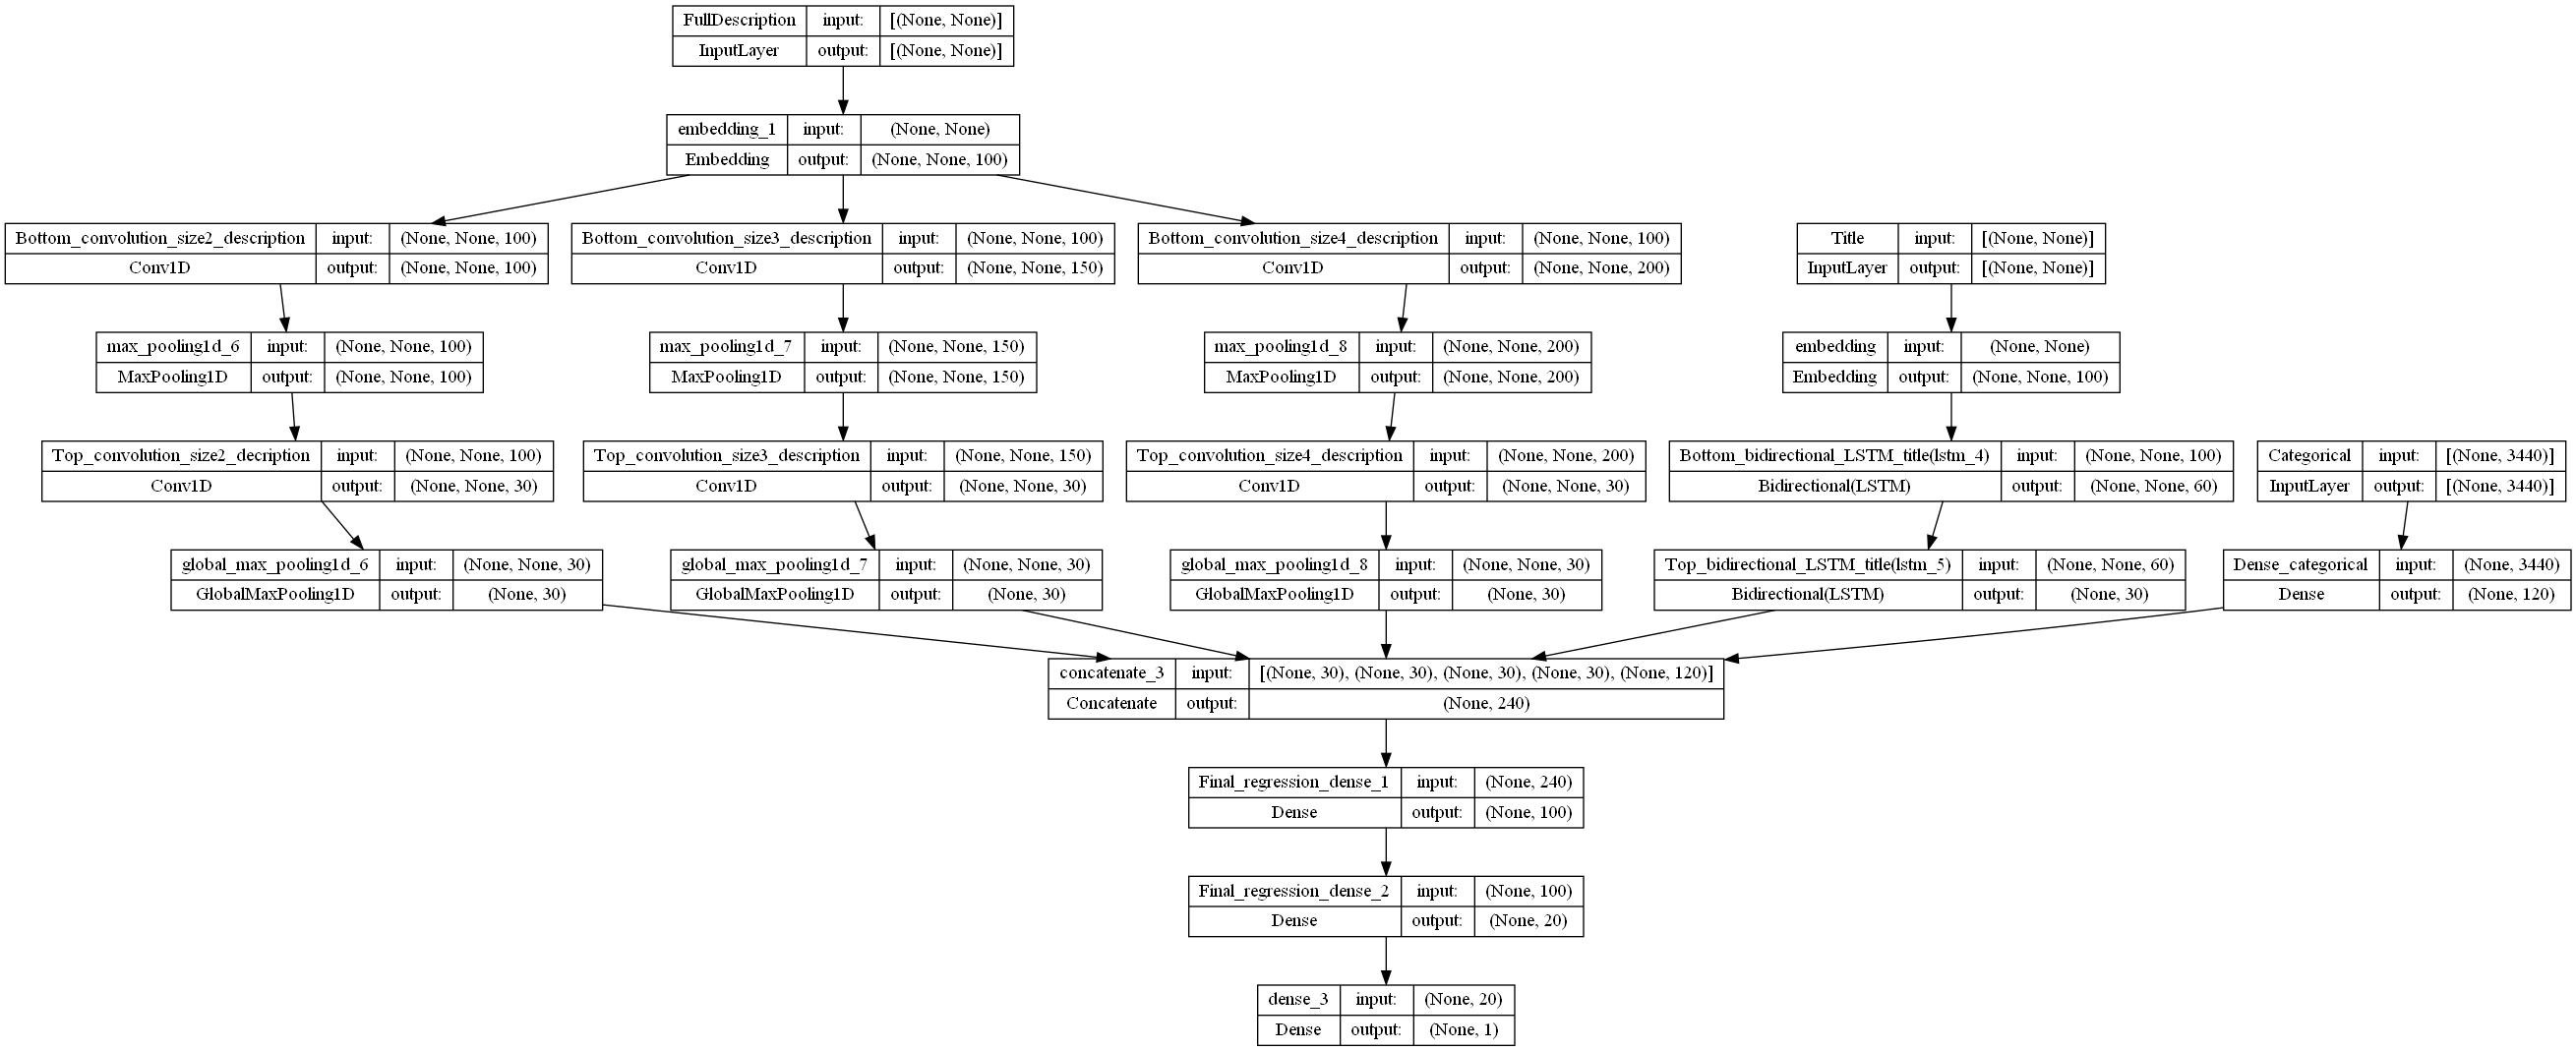

In [42]:
#plot pure recurrent model's sctructure 
plot_model(model_mix_convolutional_recurrent, show_shapes=True, show_layer_names=True)

### 3.4 Models training
To train models we will use *fit_generator* method in Keras , because our dataset is relatively large (at least for my laptop) and I don't really want to overload its memory with such amount of data. *fit_generator* method accepts a batch made from the shuffled data in the *iterate_minibatches* function (check cell 43), then performs backpropagation on it and updates model weights. These actions are performed several times per epoch: *(len(data_train) - 1) // batch_size + 1* times.

We will also use some tricks for advanced training in Keras - callbacks:
1. **PlotLearning** - this is a custom callback which plots loss and metrics during training. Its code can be seen in cell 44, in our implementation plotting starts after the 4th epoch.
2. **EarlyStopping** - Keras callback which stops training if the target metric doesn't improve within a particular number of epochs. In our case the target metric is MAE on the validation and the number of epochs with no improvement after which training will be stopped (patience) is 20. (check cell 46)
3. **ModelCheckpoint** - Keras callback which saves the Keras model or model weights at some frequency. In our case we will save only model weights for epochs when the target metric (MAE on the validation) is better than the last best one. (check cell 46)

In [43]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    
    """Iterates minibatches of data in random order """
    
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [44]:
#custom Keras Callback class to plot loss and metrics during training

from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    
    """Callback to plot learning curves during training"""
    
    def on_train_begin(self, logs={}):
        
        """Initialize metrics dictionary before training starts"""
        
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}, treshold=2):
        
        """Plot loss and metrics starting with treshold+2 epoch"""
        
        # Storing metrics
        if epoch>treshold:
            for metric in logs:
                if metric in self.metrics:
                    self.metrics[metric].append(logs.get(metric))
                else:
                    self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        
        if epoch>treshold:

            for i, metric in enumerate(metrics):
                axs[i].plot(range(treshold+2, epoch + 2), 
                            self.metrics[metric], 
                            label=metric)
                if logs['val_' + metric]:
                    axs[i].plot(range(treshold+2, epoch + 2), 
                                self.metrics['val_' + metric], 
                                label='val_' + metric)

                axs[i].legend()
                axs[i].grid()

        plt.tight_layout()
        plt.show()

In [45]:
#creating paths for saving models weigths (ModelCheckpoint callback)
import os
name_baseline=os.path.join(os.path.join(os.getcwd(), "final_baseline_weights"), 
                          '{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5')
name_pure_conv=os.path.join(os.path.join(os.getcwd(), "final_pure_conv_weights"), 
                          '{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5')
name_pure_recurr=os.path.join(os.path.join(os.getcwd(), "final_pure_recurr_weights"), 
                          '{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5')
name_mix_conv_recurr=os.path.join(os.path.join(os.getcwd(), "final_mix_conv_recurr_weights"), 
                          '{epoch:02d}-{val_mean_absolute_error:.2f}.hdf5')

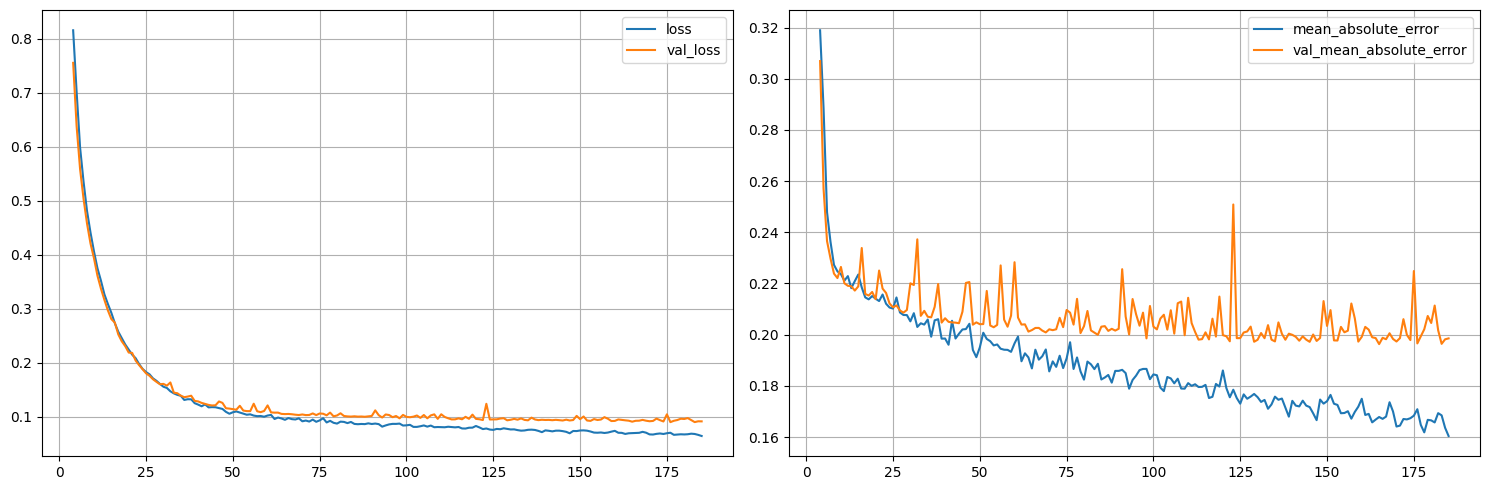

100/100 [==============================] - 13s 132ms/step - loss: 0.0642 - mean_absolute_error: 0.1604 - val_loss: 0.0913 - val_mean_absolute_error: 0.1985
Epoch 185: early stopping


In [46]:
# fitting baseline model

with tf.device('/GPU:0'):

    batch_size = 256
    epochs = 200            
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1
    
    baseline_model=build_baseline_model()
    
    #EarlyStopping callback
    earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                                                    patience=20, verbose=1, mode='min', 
                                                                    restore_best_weights=True)
    #ModelCheckpoint callback
    checkpointer=tf.keras.callbacks.ModelCheckpoint(name_baseline,
                                                   monitor='val_mean_absolute_error',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True, 
                                                   mode='min')
    
    history_baseline = baseline_model.fit_generator(
                        iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size,
                        callbacks=[earlystop, checkpointer, PlotLearning()]
                       )

During training of the pure convolutional model I got "IOPub data rate exceeded" error. In thе cell below you can see that the model seems to be frozen at 84 epoch, however, it is not exactly true. After "IOPub data rate exceeded" error the notebook just stoped displaying outputs, but the training process was not terminated and continued for all 200 epochs. You can check full learning curves plotted via Keras "history" attribute in cell 53.

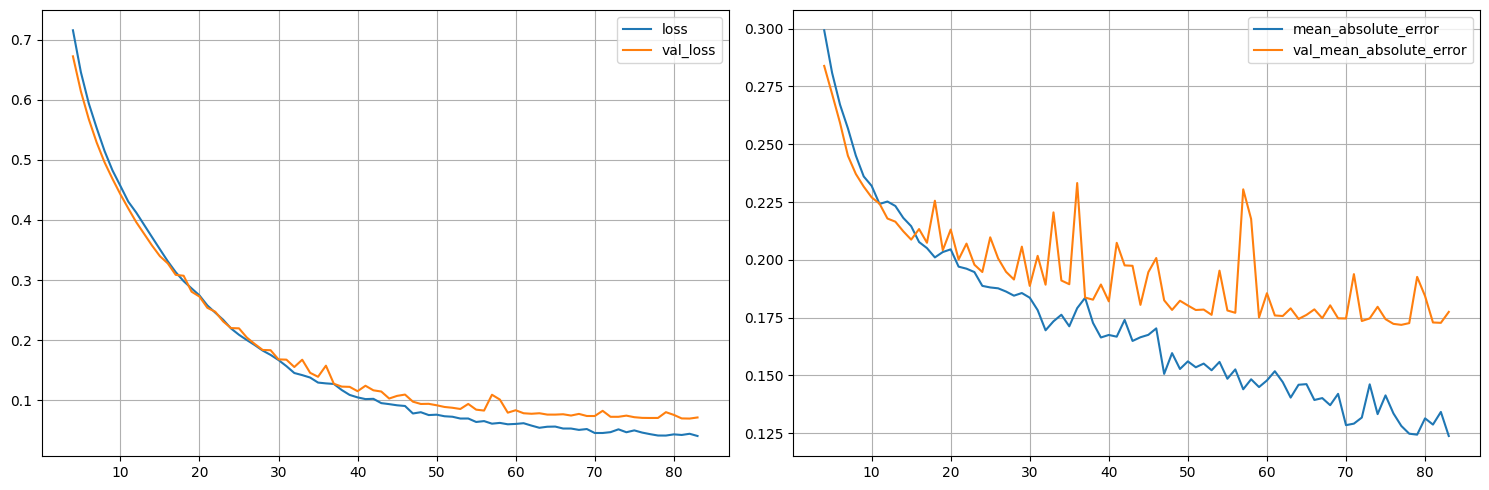

100/100 [==============================] - 29s 288ms/step - loss: 0.0408 - mean_absolute_error: 0.1237 - val_loss: 0.0716 - val_mean_absolute_error: 0.1774
Epoch 84/200
 80/100 [=======================>......] - ETA: 3s - loss: 0.0415 - mean_absolute_error: 0.1274

In [ ]:
# fitting pure convolutional model

with tf.device('/GPU:0'):

    batch_size = 256
    epochs = 200            
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1
    
    model_pure_convolutional=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
    
    #EarlyStopping callback
    earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                                                    patience=20, verbose=1, mode='min', 
                                                                    restore_best_weights=True)
    #ModelCheckpoint callback
    checkpointer=tf.keras.callbacks.ModelCheckpoint(name_pure_conv,
                                                   monitor='val_mean_absolute_error',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True, 
                                                   mode='min')
    
    history_pure_conv = model_pure_convolutional.fit_generator(
                        iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size,
                        callbacks=[earlystop, checkpointer, PlotLearning()]
                       )

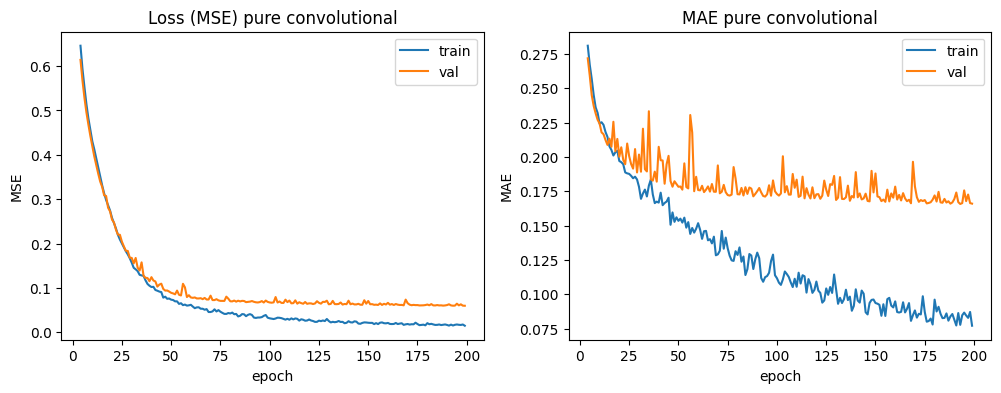

In [53]:
"""since I got "IOPub data rate exceeded" error when training pure convolutional model, full graphs from PlotLearning 
were not displayed in the output, so they are plotted in this cell via history_pure_conv variable"""

#plot MSE on train and val sets for pure convolutional model
plt.figure(figsize=[12, 4])
plt.subplot(1, 2, 1)
plt.plot(range(4,len(history_pure_conv.history['loss'])),
         history_pure_conv.history['loss'][4:])
plt.plot(range(4,len(history_pure_conv.history['val_loss'])),
               history_pure_conv.history['val_loss'][4:])
plt.title('Loss (MSE) pure convolutional')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

#plot MAE on train and val sets for pure convolutional model
plt.subplot(1, 2, 2)
plt.plot(range(4,len(history_pure_conv.history['mean_absolute_error'])),
         history_pure_conv.history['mean_absolute_error'][4:])
plt.plot(range(4,len(history_pure_conv.history['val_mean_absolute_error'])),
               history_pure_conv.history['val_mean_absolute_error'][4:])
plt.title('MAE pure convolutional')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

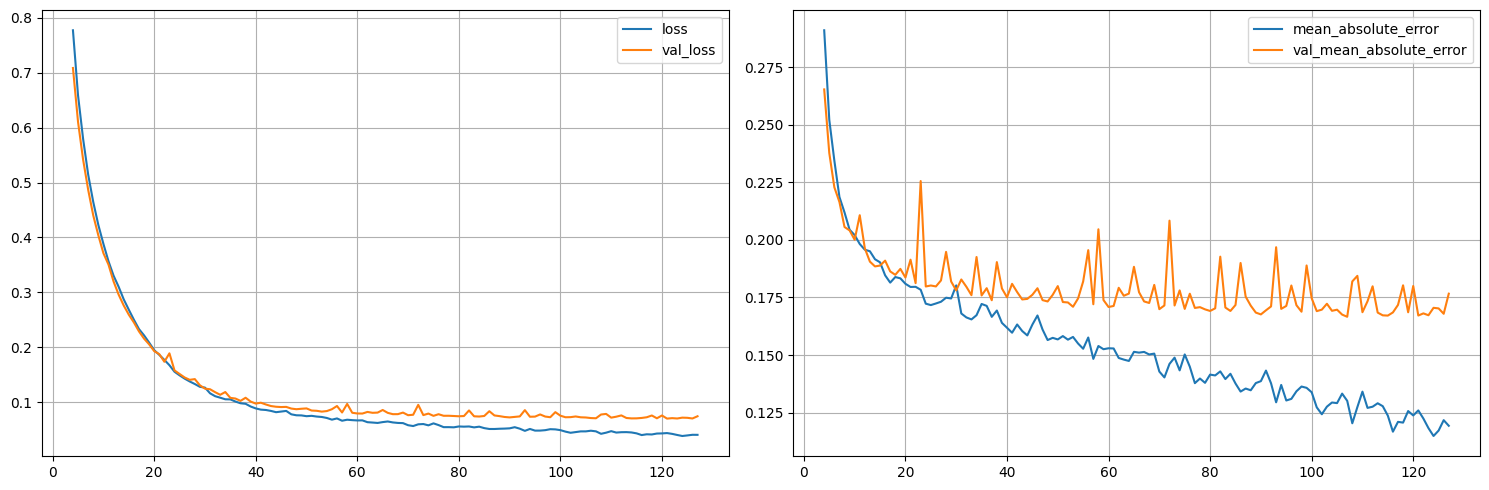

100/100 [==============================] - 50s 498ms/step - loss: 0.0407 - mean_absolute_error: 0.1193 - val_loss: 0.0745 - val_mean_absolute_error: 0.1766
Epoch 127: early stopping


In [56]:
# fitting pure recurrent model

with tf.device('/GPU:0'):

    batch_size = 256
    epochs = 200            
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1
    
    model_pure_recurrent=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
    
    #EarlyStopping callback
    earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                                                    patience=20, verbose=1, mode='min', 
                                                                    restore_best_weights=True)
    #ModelCheckpoint callback
    checkpointer=tf.keras.callbacks.ModelCheckpoint(name_pure_recurr,
                                                   monitor='val_mean_absolute_error',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True, 
                                                   mode='min')

    history_pure_recurr = model_pure_recurrent.fit_generator(
                        iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size,
                        callbacks=[earlystop, checkpointer, PlotLearning()]
                       )

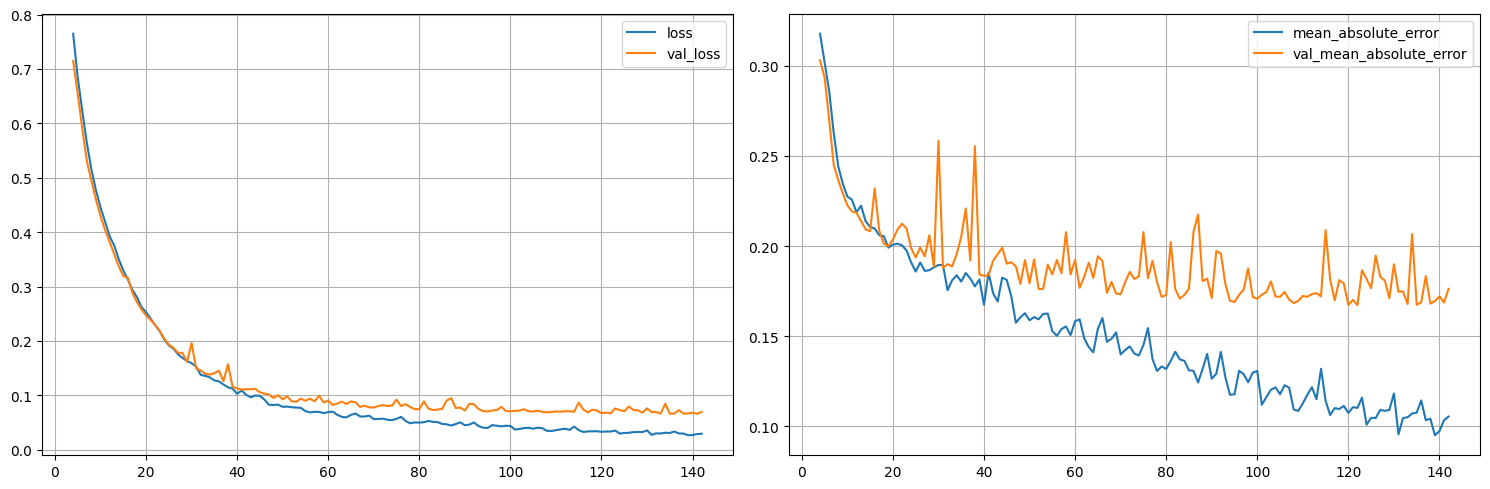

100/100 [==============================] - 29s 290ms/step - loss: 0.0293 - mean_absolute_error: 0.1054 - val_loss: 0.0692 - val_mean_absolute_error: 0.1763
Epoch 142: early stopping


In [57]:
# fitting mix convolutional+recurrent model

with tf.device('/GPU:0'):

    batch_size = 256
    epochs = 200            
    steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1
    
    model_mix_convolutional_recurrent=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
    
    #EarlyStopping callback
    earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', 
                                                                    patience=20, verbose=1, mode='min', 
                                                                    restore_best_weights=True)
    #ModelCheckpoint callback
    checkpointer=tf.keras.callbacks.ModelCheckpoint(name_mix_conv_recurr,
                                                   monitor='val_mean_absolute_error',
                                                   verbose=0,
                                                   save_best_only=True,
                                                   save_weights_only=True, 
                                                   mode='min')
    
    history_mix_conv_recurr = model_mix_convolutional_recurrent.fit_generator(
                        iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                        epochs=epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                        validation_steps=data_val.shape[0] // batch_size,
                        callbacks=[earlystop, checkpointer, PlotLearning()]
                       )

Let's briefly discuss loss (MSE) and MAE curves of different models. The first thing to notice is that for all models, except for the pure convolutional, training was terminated earlier (EarlyStopping). The possible reason of this might be the fact that the pure convolutional model has the biggest number of trainable parameters, and even after many epochs it can continue "learning" something i.e. continue improving MAE on the validation set. Secondly, pure convolutional, pure recurrent and mix models acheive nearly the same results in the train and validation loss, while the simpler baseline model showed worse perfromance. Finally, considering MAE curves, pure convolutional model showed the best results on the training set, probably because it has been trained for all 200 epochs and was able to adjust well to the training data. As you might guess, baseline model showed the worst results for the training MAE. With regards to MAE on the validation set our models could be ranked in the following oreder (from best to worst): pure convolutional, mix convolutional+recurrent, pure recurrent, baseline.


### 3.5 Models evaluation
Now we came to the last part - models evalutaion and comparison. This part is the most interesting and important, so we will not compare models just taking the best epoch for each (with the lowest validation MAE), we will use a more sophisticated method. First, we need to predict salary amount in the original form, but we trained our models for log1p(salary), so we have to transform our predictions using inverse funtion for log1p - expm1. Second, for each model we will take 5 best epochs, predict 5 values and use harmonic mean to get the final prediction (for some reasons harmonic mean works better than standart or geometic mean). Function *make_prediction_by_several_epochs* (cell 58) calculates harmonic mean of transformed predictions of several best epochs of a particular model. Function *calculate_metrics* (cell 58) calculates MSE and MAE for the given data using output of *make_prediction_by_several_epochs* function as the model's predictions.

In [58]:
from scipy.stats import hmean

def make_prediction_by_several_epochs(data, best_epochs):
    
    """Calculates harmonic mean of transformed predictions of several best epochs of a particular model"""
    
    preds=[]
    for epoch in best_epochs:
        preds.append(np.expm1(epoch.predict(data, verbose=0)[:, 0]))
        
    preds=np.array(preds, dtype=np.float32)                                             
                                                    
    return hmean(preds, axis=0)       


def calculate_metrics(best_epochs, data, batch_size=batch_size, **kw):
    
    """ 
    Calculates MSE and MAE for the given data using output of "make_prediction_by_several_epochs" function 
    as the model's predictions
    
    """
    
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = make_prediction_by_several_epochs(batch_x, best_epochs)
        batch_y_orig=np.expm1(batch_y)
        squared_error += np.sum(np.square(batch_pred - batch_y_orig))
        abs_error += np.sum(np.abs(batch_pred - batch_y_orig))
        num_samples += len(batch_y)
    return squared_error / num_samples, abs_error / num_samples

In [60]:
#sample 5 best epochs for baseline model
model_baseline1=build_baseline_model()
model_baseline1.load_weights("./final_baseline_weights/113-0.20.hdf5")
model_baseline2=build_baseline_model()
model_baseline2.load_weights("./final_baseline_weights/122-0.20.hdf5")
model_baseline3=build_baseline_model()
model_baseline3.load_weights("./final_baseline_weights/129-0.20.hdf5")
model_baseline4=build_baseline_model()
model_baseline4.load_weights("./final_baseline_weights/145-0.20.hdf5")
model_baseline5=build_baseline_model()
model_baseline5.load_weights("./final_baseline_weights/165-0.20.hdf5")

best_epochs_baseline=[model_baseline1, model_baseline2, model_baseline3, model_baseline4, model_baseline5]


#sample 5 best epochs for pure convolutional model
model_pure_conv1=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_conv1.load_weights("./final_pure_conv_weights/156-0.17.hdf5")
model_pure_conv2=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_conv2.load_weights("./final_pure_conv_weights/169-0.17.hdf5")
model_pure_conv3=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_conv3.load_weights("./final_pure_conv_weights/177-0.17.hdf5")
model_pure_conv4=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_conv4.load_weights("./final_pure_conv_weights/189-0.17.hdf5")
model_pure_conv5=build_model_pure_convolutional(embedding_matrix=embedding_matrix_wiki)
model_pure_conv5.load_weights("./final_pure_conv_weights/194-0.17.hdf5")

best_epochs_conv=[model_pure_conv1, model_pure_conv2, model_pure_conv3, model_pure_conv4, model_pure_conv5]


#sample 5 best epochs for pure recurrent model
model_pure_rec1=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_rec1.load_weights("./final_pure_recurr_weights/80-0.17.hdf5")
model_pure_rec2=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_rec2.load_weights("./final_pure_recurr_weights/89-0.17.hdf5")
model_pure_rec3=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_rec3.load_weights("./final_pure_recurr_weights/90-0.17.hdf5")
model_pure_rec4=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_rec4.load_weights("./final_pure_recurr_weights/106-0.17.hdf5")
model_pure_rec5=build_model_pure_recurrent(embedding_matrix=embedding_matrix_wiki)
model_pure_rec5.load_weights("./final_pure_recurr_weights/107-0.17.hdf5")

best_epochs_rec=[model_pure_rec1, model_pure_rec2, model_pure_rec3, model_pure_rec4, model_pure_rec5]

#sample 5 best epochs for mix (convolutional+recurrent) model
model_conv_rec1=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_conv_rec1.load_weights("./final_mix_conv_recurr_weights/94-0.17.hdf5")
model_conv_rec2=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_conv_rec2.load_weights("./final_mix_conv_recurr_weights/95-0.17.hdf5")
model_conv_rec3=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_conv_rec3.load_weights("./final_mix_conv_recurr_weights/108-0.17.hdf5")
model_conv_rec4=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_conv_rec4.load_weights("./final_mix_conv_recurr_weights/120-0.17.hdf5")
model_conv_rec5=build_model_mix_convolutional_recurrent(embedding_matrix=embedding_matrix_wiki)
model_conv_rec5.load_weights("./final_mix_conv_recurr_weights/122-0.17.hdf5")

best_epochs_conv_rec=[model_conv_rec1, model_conv_rec2, model_conv_rec3, model_conv_rec4, model_conv_rec5]

In [63]:
#evaluation of baseline model
mse_train_baseline, mae_train_baseline=calculate_metrics(best_epochs_baseline, data_train)
mse_val_baseline, mae_val_baseline=calculate_metrics(best_epochs_baseline, data_val)
print('===========================')
print("For baseline model")
print("\nTrain results:")
print("Mean square error: %.5f" % (mse_train_baseline))
print("Mean absolute error: %.5f" % (mae_train_baseline))

print("\nValidation results:")
print("Mean square error: %.5f" % (mse_val_baseline))
print("Mean absolute error: %.5f" % (mae_val_baseline))
print('===========================')

#evaluation of pure convolutional model
mse_train_conv, mae_train_conv=calculate_metrics(best_epochs_conv, data_train)
mse_val_conv, mae_val_conv=calculate_metrics(best_epochs_conv, data_val)
print('===========================')
print("For pure convolutional model")
print("\nTrain results:")
print("Mean square error: %.5f" % (mse_train_conv))
print("Mean absolute error: %.5f" % (mae_train_conv))

print("\nValidation results:")
print("Mean square error: %.5f" % (mse_val_conv))
print("Mean absolute error: %.5f" % (mae_val_conv))
print('===========================')

#evaluation of pure recurrent model
mse_train_rec, mae_train_rec=calculate_metrics(best_epochs_rec, data_train)
mse_val_rec, mae_val_rec=calculate_metrics(best_epochs_rec, data_val)
print('===========================')
print("For pure recurrent model")
print("\nTrain results:")
print("Mean square error: %.5f" % (mse_train_rec))
print("Mean absolute error: %.5f" % (mae_train_rec))

print("\nValidation results:")
print("Mean square error: %.5f" % (mse_val_rec))
print("Mean absolute error: %.5f" % (mae_val_rec))
print('===========================')

#evaluation of mix convolutional+recurrent model
mse_train_conv_rec, mae_train_conv_rec=calculate_metrics(best_epochs_conv_rec, data_train)
mse_val_conv_rec, mae_val_conv_rec=calculate_metrics(best_epochs_conv_rec, data_val)
print('===========================')
print("For mix (convolutional+recurrent) model")
print("\nTrain results:")
print("Mean square error: %.5f" % (mse_train_conv_rec))
print("Mean absolute error: %.5f" % (mae_train_conv_rec))

print("\nValidation results:")
print("Mean square error: %.5f" % (mse_val_conv_rec))
print("Mean absolute error: %.5f" % (mae_val_conv_rec))
print('===========================')

For baseline model

Train results:
Mean square error: 87683104.62655
Mean absolute error: 5711.16533

Validation results:
Mean square error: 119837185.67341
Mean absolute error: 6839.72044
For pure convolutional model

Train results:
Mean square error: 6117655.06417
Mean absolute error: 1533.23777

Validation results:
Mean square error: 85973176.04347
Mean absolute error: 5627.65516
For pure recurrent model

Train results:
Mean square error: 44882081.34168
Mean absolute error: 4040.23802

Validation results:
Mean square error: 86951344.72231
Mean absolute error: 5770.05218
For mix (convolutional+recurrent) model

Train results:
Mean square error: 21537209.54359
Mean absolute error: 2794.95819

Validation results:
Mean square error: 86016078.73383
Mean absolute error: 5728.19886


For better representation let's plot MAE on the train validation sets for all considered models (cell 69). From these figures, we can notice that on both train and validation MAE pure convolutional model showed the best perforamnce (congrats, we have a winner!), while baseline model, as expected showed the worst performance. It's worth noting that on the validation set pure recurrent and mix models showed nearly the same results, while the former lost on the train set.

Text(0.5, 1.0, 'Validation MAE')

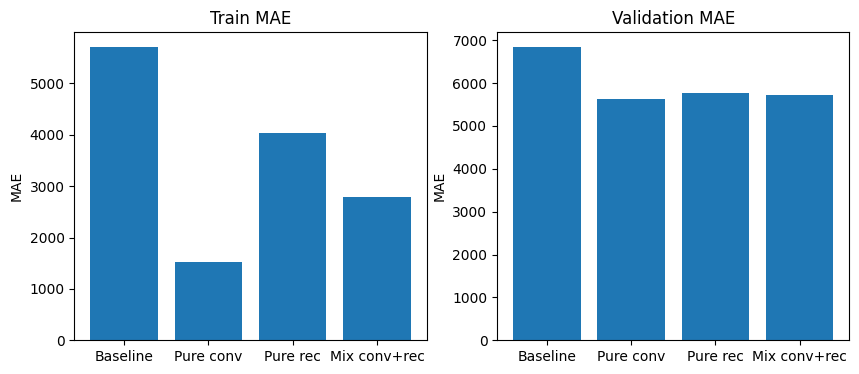

In [69]:
#plot MAE on the train and validation sets for all models
plt.figure(figsize=[10, 4])

plt.subplot(1,2,1)
plt.bar(['Baseline', 'Pure conv', 'Pure rec', 'Mix conv+rec'], [mae_train_baseline, mae_train_conv, mae_train_rec, mae_train_conv_rec])
plt.ylabel('MAE')
plt.title("Train MAE")

plt.subplot(1,2,2)
plt.bar(['Baseline', 'Pure conv', 'Pure rec', 'Mix conv+rec'], [mae_val_baseline, mae_val_conv, mae_val_rec, mae_val_conv_rec])
plt.ylabel('MAE')
plt.title("Validation MAE")

## Appendix

### Pre-trained embeddings comparison
Here we will make a simple comparison of the wiki and twitter embeddings. Number of the missed words for the wiki embeddings is considerably lower 6309 vs 7918 (cell 70). It implies that the wiki embeddings are more preferable for our specific task.

In [70]:
#download GloVe twitter embeddings with vectors size 100
embeddings_twit=api.load('glove-twitter-100')

#number of missed and converted words for the wiki embeddings
print("For wiki embeddings")
embedding_matrix_wiki=make_embedding_matrix(token_to_id, embeddings_wiki)

print('\n')

#number of missed and converted words for the twitter embeddings
print("For twitter embeddings")
embedding_matrix_twit=make_embedding_matrix(token_to_id, embeddings_twit)

For wiki embeddings
Converted 20414 words (6309 misses).


For twitter embeddings
Converted 18805 words (7918 misses).
